In [1]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"



### Load MODA data

In [2]:
modapath="C:/Users/Gurdiel/Code/MODA_GC-3.0/input"

In [3]:
epochViews=pd.read_csv(modapath+"/1_EpochViews_exp_re.txt",sep='\t')

In [4]:
epochViews.head()

,filename,epochNum,blockNum,phase,annotatorID,hitId,assignmentId,Unnamed: 7
0,e1186-b1-01-03-0045-smp379001.png,1186,1,phase1,6,NaN,NaN,NaN
1,e1187-b1-01-03-0045-smp381251.png,1187,1,phase1,6,NaN,NaN,NaN
2,e1188-b1-01-03-0045-smp383501.png,1188,1,phase1,6,NaN,NaN,NaN
3,e1189-b1-01-03-0045-smp385751.png,1189,1,phase1,6,NaN,NaN,NaN
4,e1190-b1-01-03-0045-smp388001.png,1190,1,phase1,6,NaN,NaN,NaN


In [5]:
eventLocations=pd.read_csv(modapath+"/3_EventLocations_exp_re.txt",sep='\t')

In [6]:
eventLocations.head()

,filename,phase,subID,epochNum,blockNum,annotatorID,MODA_batchNum,annotatorEventIndex,startPercent,durationPercent,startSecs,durationSecs,scoreConfidence,TimeWindowFirstShown,TimeMarkerCreated,TimeMarkerLastModified,turkHitId,turkAssignmentId,Unnamed: 18
0,e1186-b1-01-03-0045-smp379001.png,phase1,01-03-0045,1186,1,6,3,60,0.229018,0.036984,5.725462,0.924609,high,1520429129121,1520429132017,1520429134153,NaN,NaN,NaN
1,e1186-b1-01-03-0045-smp379001.png,phase1,01-03-0045,1186,1,6,3,61,0.462304,0.041252,11.557610,1.031294,high,1520429129121,1520429135619,1520429137611,NaN,NaN,NaN
2,e1189-b1-01-03-0045-smp385751.png,phase1,01-03-0045,1189,1,6,3,62,0.816501,0.045519,20.412518,1.137980,high,1520429151681,1520429153537,1520429155177,NaN,NaN,NaN
3,e0177-b6-01-05-0005-smp906251.png,phase1,01-05-0005,177,6,6,59,25,0.381935,0.039829,9.548364,0.995733,high,1520428826388,1520428828027,1520428830006,NaN,NaN,NaN
4,e0178-b6-01-05-0005-smp908501.png,phase1,01-05-0005,178,6,6,59,26,0.355619,0.021337,8.890469,0.533428,high,1520428831507,1520428833644,1520428836783,NaN,NaN,NaN


In [7]:
np.max(eventLocations.startSecs)

24.91109530583215

In [8]:
len(eventLocations)

38088

In [9]:
userType=pd.read_csv(modapath+"/5_userSubtypeAnonymLUT_exp_re.txt",sep='\t')

In [10]:
userType.head()

,userName,userSubType,Unnamed: 2
0,6,psgTech,NaN
1,7,researcher,NaN
2,8,psgTech,NaN
3,9,psgTech,NaN
4,10,psgTech,NaN


In [11]:
len(userType)

65

### Correct imprecisions of eventLocations

In [12]:
eventLocations['stopSecs']=eventLocations.startSecs+eventLocations.durationSecs

In [13]:
#check for startSecs < 0 and set to 0
len(eventLocations[eventLocations.startSecs<0])

16

In [14]:
eventLocations.loc[eventLocations.startSecs<0,'startSecs']=0

In [15]:
#check for stopSecs > 25 and set to 25
len(eventLocations[eventLocations.stopSecs>25])

400

In [16]:
eventLocations.loc[eventLocations.stopSecs>25,'stopSecs']=25

In [17]:
#check for startSecs>=stopSecs
len(eventLocations[eventLocations.startSecs>=eventLocations.stopSecs])

0

In [18]:
#reset durations for consistency
eventLocations['durationSecs']=eventLocations.stopSecs-eventLocations.startSecs

In [19]:
eventLocations[['startSecs','stopSecs','durationSecs']].head()

,startSecs,stopSecs,durationSecs
0,5.725462,6.650071,0.924609
1,11.557610,12.588905,1.031294
2,20.412518,21.550498,1.137980
3,9.548364,10.544097,0.995733
4,8.890469,9.423898,0.533428


### Filter psgTech only

In [20]:
userPsgTech=userType[userType.userSubType=='psgTech']

In [21]:
len(userPsgTech)

47

### Filter epochViews of phase1 and psgTech

In [22]:
epochViewsP1=epochViews[epochViews.phase=="phase1"]

In [23]:
len(epochViewsP1)

17089

In [24]:
epochViewsP1PsgTech=epochViewsP1[epochViewsP1.annotatorID.isin(userPsgTech.userName)]

In [25]:
len(epochViewsP1PsgTech)

10453

### Iterate pairs of different users

In [26]:
uniqueUsers=np.unique(userPsgTech.userName)

In [27]:
uniqueUsers

array([ 0,  2,  4,  6,  8,  9, 10, 11, 12, 13, 15, 17, 20, 23, 25, 29, 31,
       35, 37, 39, 40, 41, 42, 43, 44, 47, 48, 49, 51, 52, 54, 55, 57, 58,
       60, 61, 62, 65, 66, 68, 69, 70, 72, 73, 74, 75, 78], dtype=int64)

In [28]:
len(uniqueUsers)

47

start with two users selected at hand

In [29]:
userA=0
userB=2

In [30]:
epochViewsP1UserA=epochViewsP1[epochViewsP1.annotatorID==userA]
epochViewsP1UserB=epochViewsP1[epochViewsP1.annotatorID==userB]

In [31]:
innerJoin=epochViewsP1UserA.merge(epochViewsP1UserB,on=['epochNum','blockNum'],how='inner')

In [32]:
innerJoin.head()

,filename_x,epochNum,blockNum,phase_x,annotatorID_x,hitId_x,assignmentId_x,Unnamed: 7_x,filename_y,phase_y,annotatorID_y,hitId_y,assignmentId_y,Unnamed: 7_y
0,e1171-b1-01-03-0044-smp533001.png,1171,1,phase1,0,NaN,NaN,NaN,e1171-b1-01-03-0044-smp533001.png,phase1,2,NaN,NaN,NaN
1,e1172-b1-01-03-0044-smp535251.png,1172,1,phase1,0,NaN,NaN,NaN,e1172-b1-01-03-0044-smp535251.png,phase1,2,NaN,NaN,NaN
2,e1173-b1-01-03-0044-smp537501.png,1173,1,phase1,0,NaN,NaN,NaN,e1173-b1-01-03-0044-smp537501.png,phase1,2,NaN,NaN,NaN
3,e1174-b1-01-03-0044-smp539751.png,1174,1,phase1,0,NaN,NaN,NaN,e1174-b1-01-03-0044-smp539751.png,phase1,2,NaN,NaN,NaN
4,e1175-b1-01-03-0044-smp542001.png,1175,1,phase1,0,NaN,NaN,NaN,e1175-b1-01-03-0044-smp542001.png,phase1,2,NaN,NaN,NaN


In [33]:
eventsUserA=pd.DataFrame()
eventsUserB=pd.DataFrame()

separatorSecs=1
blockDurationSecs=25
count=0

for ind,row in innerJoin.iterrows():
    #user A
    thisEventsUserA=eventLocations[eventLocations.annotatorID==userA]
    thisEventsUserA=thisEventsUserA[thisEventsUserA.epochNum==row.epochNum]
    thisEventsUserA=thisEventsUserA[thisEventsUserA.blockNum==row.blockNum]
    thisEventsUserA['startSecs']=thisEventsUserA['startSecs']+count*(blockDurationSecs+separatorSecs)
    thisEventsUserA['stopSecs']=thisEventsUserA['stopSecs']+count*(blockDurationSecs+separatorSecs)
    thisEventsUserA['count']=count

    #user B
    thisEventsUserB=eventLocations[eventLocations.annotatorID==userB]
    thisEventsUserB=thisEventsUserB[thisEventsUserB.epochNum==row.epochNum]
    thisEventsUserB=thisEventsUserB[thisEventsUserB.blockNum==row.blockNum]
    thisEventsUserB['startSecs']=thisEventsUserB['startSecs']+count*(blockDurationSecs+separatorSecs)
    thisEventsUserB['stopSecs']=thisEventsUserB['stopSecs']+count*(blockDurationSecs+separatorSecs)
    thisEventsUserB['count']=count
    
    eventsUserA=pd.concat([eventsUserA,thisEventsUserA])
    eventsUserB=pd.concat([eventsUserB,thisEventsUserB])

    count=count+1
    


In [34]:
eventsUserA[['startSecs','stopSecs','count','scoreConfidence']]

,startSecs,stopSecs,count,scoreConfidence
6550,0.391181,0.924609,0,med
6551,3.200569,3.573969,0,med
6552,13.264580,13.940256,0,high
6553,12.588905,12.944523,0,med
6554,18.563300,19.292319,0,high
...,...,...,...,...
13102,8570.767425,8571.940967,329,high
13103,8574.092461,8574.821479,329,high
13104,8576.261735,8576.688478,329,high
13105,8589.832859,8590.206259,330,high


In [35]:
eventsUserB[['startSecs','stopSecs','count','scoreConfidence']]

,startSecs,stopSecs,count,scoreConfidence
19830,0.408962,0.977952,0,med
19831,3.147226,3.591750,0,med
19832,18.634424,19.185633,0,high
19833,21.941679,22.546230,0,high
19834,56.356330,57.298720,2,med
...,...,...,...,...
20713,8570.700469,8571.874011,329,high
20714,8574.061066,8574.790085,329,high
20715,8576.248122,8576.621522,329,high
20716,8589.837027,8590.174864,330,high


In [36]:
#override getIoU to work with seconds column
def getIoUmatrix(annotations,detections):
    #get the coords
    """ gtCoords=zip(annotations.startInd,annotations.stopInd)
    outCoords=zip(detections.startInd,detections.stopInd) """
    gtCoords=zip(annotations.startSecs,annotations.stopSecs)
    outCoords=zip(detections.startSecs,detections.stopSecs)
    #calculate the iou vector
    iouVector=np.array(list(itt.starmap(getIou,itt.product(gtCoords,outCoords))))
    #reshape to a matrix
    iouMatrix=iouVector.reshape(len(annotations),len(detections))
    return iouMatrix

In [37]:
iouMatrix=getIoUmatrix(eventsUserA,eventsUserB)
f1=IoUmatrixToF1(iouMatrix,thresIoU=0.3)
print(f1)

0.5039177277179236


get a list of all possible pairs

In [38]:
uniquePairs=list(itt.combinations(uniqueUsers, 2))
uniquePairs

[(0, 2),
 (0, 4),
 (0, 6),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 15),
 (0, 17),
 (0, 20),
 (0, 23),
 (0, 25),
 (0, 29),
 (0, 31),
 (0, 35),
 (0, 37),
 (0, 39),
 (0, 40),
 (0, 41),
 (0, 42),
 (0, 43),
 (0, 44),
 (0, 47),
 (0, 48),
 (0, 49),
 (0, 51),
 (0, 52),
 (0, 54),
 (0, 55),
 (0, 57),
 (0, 58),
 (0, 60),
 (0, 61),
 (0, 62),
 (0, 65),
 (0, 66),
 (0, 68),
 (0, 69),
 (0, 70),
 (0, 72),
 (0, 73),
 (0, 74),
 (0, 75),
 (0, 78),
 (2, 4),
 (2, 6),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 15),
 (2, 17),
 (2, 20),
 (2, 23),
 (2, 25),
 (2, 29),
 (2, 31),
 (2, 35),
 (2, 37),
 (2, 39),
 (2, 40),
 (2, 41),
 (2, 42),
 (2, 43),
 (2, 44),
 (2, 47),
 (2, 48),
 (2, 49),
 (2, 51),
 (2, 52),
 (2, 54),
 (2, 55),
 (2, 57),
 (2, 58),
 (2, 60),
 (2, 61),
 (2, 62),
 (2, 65),
 (2, 66),
 (2, 68),
 (2, 69),
 (2, 70),
 (2, 72),
 (2, 73),
 (2, 74),
 (2, 75),
 (2, 78),
 (4, 6),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 15),
 (4, 17),
 (4, 20),
 (

In [39]:
#check the number is equal to the number of pairs possible (for 47 elements): 46+45+44+...+3+2+1=1081
len(list(itt.combinations(uniqueUsers, 2)))

1081

In [40]:
#control variables
separatorSecs=1
blockDurationSecs=25

#arrays to create a overall dataframe
allUserA=np.array([])
allUserB=np.array([])
allEpochsCommon=np.array([])
allF1=np.array([])

#iterate all possible pairs
for pair in uniquePairs:
    userA=pair[0]
    userB=pair[1]

    #epoch views for each user in the pair
    epochViewsP1UserA=epochViewsP1[epochViewsP1.annotatorID==userA]
    epochViewsP1UserB=epochViewsP1[epochViewsP1.annotatorID==userB]

    #common epoch views
    innerJoin=epochViewsP1UserA.merge(epochViewsP1UserB,on=['epochNum','blockNum'],how='inner')
    epochsCommon=len(innerJoin)

    #make the loop conditional to at least one comon epoch view
    if epochsCommon>0:

        #initialise counter and eventUser data frames
        count=0
        eventsUserA=pd.DataFrame()
        eventsUserB=pd.DataFrame()

        #loop each epoch common to simulate all epochs temporally concatenated with the given separation
        for ind,row in innerJoin.iterrows():

            #user A
            thisEventsUserA=eventLocations[eventLocations.annotatorID==userA]
            thisEventsUserA=thisEventsUserA[thisEventsUserA.epochNum==row.epochNum]
            thisEventsUserA=thisEventsUserA[thisEventsUserA.blockNum==row.blockNum]
            thisEventsUserA['startSecs']=thisEventsUserA['startSecs']+count*(blockDurationSecs+separatorSecs)
            thisEventsUserA['stopSecs']=thisEventsUserA['stopSecs']+count*(blockDurationSecs+separatorSecs)
            thisEventsUserA['count']=count

            #user B
            thisEventsUserB=eventLocations[eventLocations.annotatorID==userB]
            thisEventsUserB=thisEventsUserB[thisEventsUserB.epochNum==row.epochNum]
            thisEventsUserB=thisEventsUserB[thisEventsUserB.blockNum==row.blockNum]
            thisEventsUserB['startSecs']=thisEventsUserB['startSecs']+count*(blockDurationSecs+separatorSecs)
            thisEventsUserB['stopSecs']=thisEventsUserB['stopSecs']+count*(blockDurationSecs+separatorSecs)
            thisEventsUserB['count']=count

            #concatenation
            eventsUserA=pd.concat([eventsUserA,thisEventsUserA])
            eventsUserB=pd.concat([eventsUserB,thisEventsUserB])

            #upload counter
            count=count+1
            
        #calculate f1 metric
        iouMatrix=getIoUmatrix(eventsUserA,eventsUserB)
        try:
            f1=IoUmatrixToF1(iouMatrix,thresIoU=0.3)

        except ValueError:
            #empty matrices, set f1 to NaN
            f1=np.NaN

        #append results
        allUserA=np.concatenate((allUserA,[userA]),axis=0)
        allUserB=np.concatenate((allUserB,[userB]),axis=0)
        allEpochsCommon=np.concatenate((allEpochsCommon,[epochsCommon]),axis=0)
        allF1=np.concatenate((allF1,[f1]),axis=0)

    #keep track of pairs with no common epoch
    else:
        #append results
        allUserA=np.concatenate((allUserA,[userA]),axis=0)
        allUserB=np.concatenate((allUserB,[userB]),axis=0)
        allEpochsCommon=np.concatenate((allEpochsCommon,[0]),axis=0)
        allF1=np.concatenate((allF1,[np.NaN]),axis=0)
    
#define overall dataframe
overallDf=pd.DataFrame({
    'userA':allUserA,
    'userB':allUserB,
    'epochsCommon':allEpochsCommon,
    'f1':allF1
})

In [51]:
checkNan=overallDf.f1.isnull()

In [77]:
len(overallDf[~checkNan])

371

### consider all cases

In [95]:
resultsDf=overallDf[(~checkNan)&(overallDf.epochsCommon>0)]

In [96]:
resultsDf.describe()

,userA,userB,epochsCommon,f1
count,371.000000,371.000000,371.000000,371.000000
mean,25.210243,52.000000,59.266846,0.658766
std,19.143103,17.755547,145.915308,0.183616
min,0.000000,2.000000,1.000000,0.142857
25%,7.000000,41.000000,5.000000,0.533333
50%,25.000000,54.000000,10.000000,0.695652
75%,41.000000,69.000000,31.000000,0.782609
max,70.000000,78.000000,1205.000000,1.000000


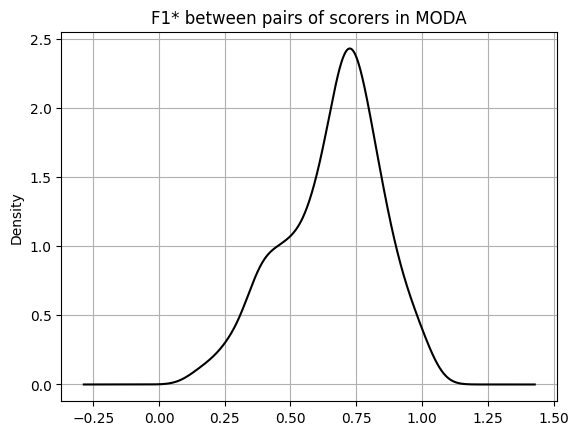

In [102]:
resultsDf.f1.plot.density(color='black')
plt.title('F1* between pairs of scorers in MODA')
plt.grid()
plt.show()

### consider cases with at least 10 epochs in common

In [63]:
resultsDf=overallDf[(~checkNan)&(overallDf.epochsCommon>9)]

In [64]:
resultsDf.describe()

,userA,userB,epochsCommon,f1
count,210.000000,210.000000,210.000000,210.000000
mean,24.457143,51.909524,100.900000,0.639732
std,19.162627,17.203994,183.518599,0.163515
min,0.000000,2.000000,10.000000,0.166667
25%,6.000000,41.000000,10.000000,0.522402
50%,25.000000,52.000000,24.000000,0.683804
75%,41.000000,69.000000,92.750000,0.749428
max,70.000000,78.000000,1205.000000,1.000000


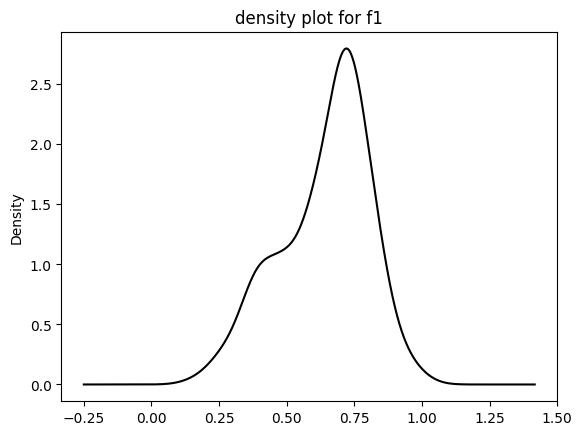

In [67]:
resultsDf.f1.plot.density(color='black')
plt.vlines()
plt.title('density plot for f1')
plt.show()

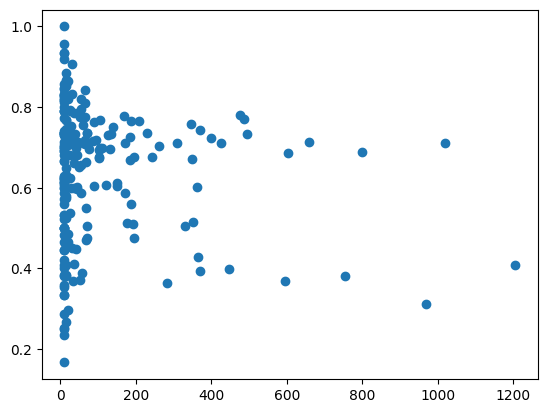

In [68]:
plt.scatter(resultsDf.epochsCommon,resultsDf.f1)

### consider cases with at least 200 epochs in common

In [88]:
resultsDf=overallDf[(~checkNan)&(overallDf.epochsCommon>199)]

In [89]:
resultsDf.describe()

,userA,userB,epochsCommon,f1
count,28.000000,28.000000,28.000000,28.000000
mean,20.428571,49.357143,489.500000,0.605522
std,19.857695,19.152825,253.586204,0.158425
min,0.000000,2.000000,208.000000,0.310689
25%,0.000000,41.000000,341.500000,0.422287
50%,18.500000,44.000000,385.000000,0.687082
75%,38.000000,70.000000,596.500000,0.726478
max,69.000000,70.000000,1205.000000,0.779279


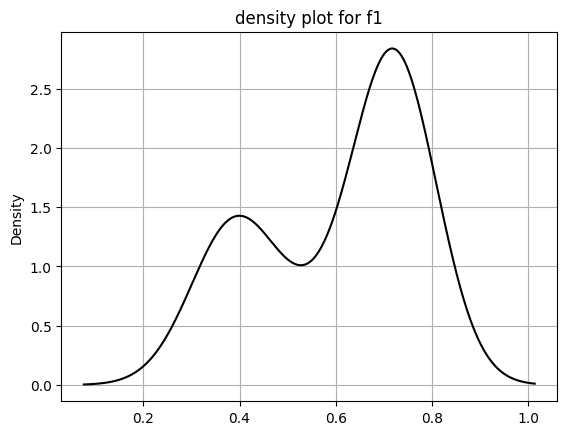

In [90]:
resultsDf.f1.plot.density(color='black')
plt.title('density plot for f1')
plt.grid()
plt.show()

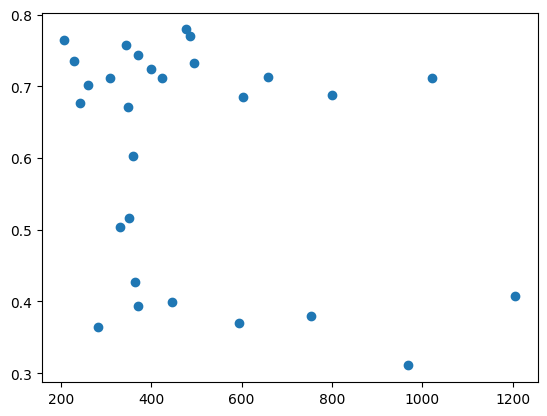

In [91]:
plt.scatter(resultsDf.epochsCommon,resultsDf.f1)

In [92]:
resultsDf

,userA,userB,epochsCommon,f1
0,0.0,2.0,331.0,0.503918
7,0.0,12.0,370.0,0.393953
13,0.0,25.0,446.0,0.399486
15,0.0,31.0,283.0,0.363692
17,0.0,37.0,365.0,0.427107
20,0.0,41.0,1205.0,0.407828
23,0.0,44.0,753.0,0.380088
39,0.0,69.0,594.0,0.369315
40,0.0,70.0,969.0,0.310689
65,2.0,41.0,361.0,0.603106


In [93]:
np.unique(np.concatenate((resultsDf.userA,resultsDf.userB)))

array([ 0.,  2., 12., 25., 31., 37., 41., 42., 44., 69., 70.])

In [94]:
len(np.unique(np.concatenate((resultsDf.userA,resultsDf.userB))))

11